# Getting started

In this notebook, we use `torchsurv` to train a model that predicts relative risk of breast cancer recurrence. We use a public data set, the [German Breast Cancer Study Group 2 (GBSG2)](https://paperswithcode.com/dataset/gbsg2). After training the model, we evaluate the predictive performance using evaluation metrics implemented in `torchsurv`.


We first load the dataset using the [lifelines](https://lifelines.readthedocs.io/en/latest/) package. The GBSG2 dataset contains features and recurrence free survival time (in days) for 686 women undergoing hormonal treatment. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Our package
from torchsurv.loss.cox import neg_partial_log_likelihood
from torchsurv.loss.weibull import neg_log_likelihood, log_hazard, survival_function
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex
from torchsurv.metrics.auc import Auc

# local helpers
from helpers_introduction import Custom_dataset, plot_losses

In [3]:
# Constant parameters accross models
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-2

## Dataset overview

In [4]:
# Load GBSG2 dataset
df = lifelines.datasets.load_gbsg2()
df.head(5)

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


The dataset contains the categorical features: 

- `horTh`: hormonal therapy, a factor at two levels (yes and no).
- `age`:  age of the patients in years.
- `menostat`: menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal).
- `tsize`: tumor size (in mm).
- `tgrade`: tumor grade, a ordered factor at levels I < II < III.
- `pnodes`: number of positive nodes.
- `progrec`: progesterone receptor (in fmol).
- `estrec`: estrogen receptor (in fmol).

Additionally, it contains our survival targets:

- `time`: recurrence free survival time (in days).
- `cens`: censoring indicator (0- censored, 1- event).

One common approach is to use a [one hot encoder](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to convert them into numerical features. We then seperate the dataframes into features `X` and labels `y`. The following code also partitions the labels and features into training and testing cohorts.

## Data preparation

In [32]:
df_onehot = pd.get_dummies(df, columns=["horTh", "menostat", "tgrade"]).astype("float")
df_onehot.drop(
    ["horTh_no", "menostat_Post", "tgrade_I"],
    axis=1,
    inplace=True,
)
df_onehot.head(5)

,age,tsize,pnodes,progrec,estrec,time,horTh_yes,menostat_Pre,tgrade_II,tgrade_III,event
0,70.0,21.0,3.0,48.0,66.0,1814.0,0.0,0.0,1.0,0.0,False
1,56.0,12.0,7.0,61.0,77.0,2018.0,1.0,0.0,1.0,0.0,False
2,58.0,35.0,9.0,52.0,271.0,712.0,1.0,0.0,1.0,0.0,False
3,59.0,17.0,4.0,60.0,29.0,1807.0,1.0,0.0,1.0,0.0,False
4,73.0,35.0,1.0,26.0,65.0,772.0,0.0,0.0,1.0,0.0,False


In [6]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3)
df_train, df_val = train_test_split(df_train, test_size=0.3)
print(
    f"(Sample size) Training:{len(df_train)} | Validation:{len(df_val)} |Testing:{len(df_test)}"
)

(Sample size) Training:336 | Validation:144 |Testing:206


Let us setup the dataloaders for training, validation and testing.

In [7]:
# Dataloader
dataloader_train = DataLoader(
    Custom_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    Custom_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    Custom_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [8]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features = x.size(1)

print(f"x (shape)    = {x.shape}")
print(f"num_features = {num_features}")
print(f"event        = {event.shape}")
print(f"time         = {time.shape}")

x (shape)    = torch.Size([32, 9])
num_features = 9
event        = torch.Size([32])
time         = torch.Size([32])


## Section 1: Cox proportional hazards model

In this section, we use the [Cox proportional hazards model](../_autosummary/torchsurv.loss.cox.html). Given covariate $x_{i}$, the hazard of patient $i$ has the form
$$
\lambda (t|x_{i}) =\lambda_{0}(t)\theta(x_{i})
$$
The baseline hazard $\lambda_{0}(t)$ is identical across subjects (i.e., has no dependency on $i$). The subject-specific risk of event occurence is captured through the relative hazards $\{\theta(x_{i})\}_{i = 1, \dots, N}$.

We train a multi-layer perceptron (MLP) to model the subject-specific risk of event occurence, i.e., the log relative hazards $\log\theta(x_{i})$. Patients with lower recurrence time are assumed to have higher risk of event. 

### Section 1.1: MLP model for log relative hazards

In [9]:
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)

### Section 1.2: MLP model training

In [10]:
torch.manual_seed(42)

# Init optimizer for Cox
optimizer = torch.optim.Adam(cox_model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_hz = cox_model(x)  # shape = (16, 1)
        loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Reccord loss on train and test sets
    epoch_loss /= i + 1
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(
            neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean")
        )

Epoch: 000, Training loss: 47.81
Epoch: 010, Training loss: 44.93
Epoch: 020, Training loss: 43.78
Epoch: 030, Training loss: 44.77
Epoch: 040, Training loss: 43.74
Epoch: 050, Training loss: 45.28
Epoch: 060, Training loss: 43.95
Epoch: 070, Training loss: 46.27
Epoch: 080, Training loss: 46.49
Epoch: 090, Training loss: 44.58


We can visualize the training and validation losses.

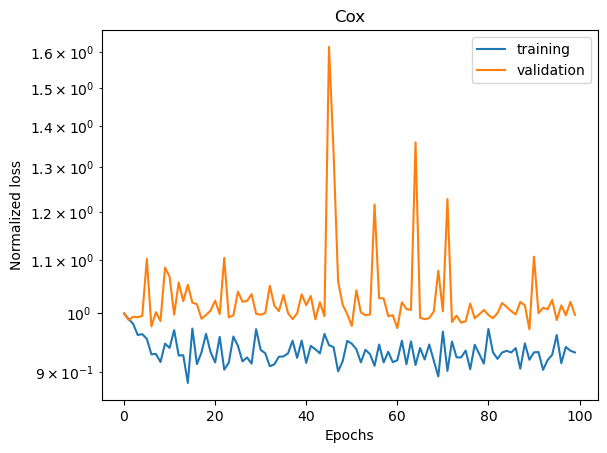

In [11]:
plot_losses(train_losses, val_losses, "Cox")

### Section 1.3: Cox proportional hazards model evaluation

We evaluate the predictive performance of the model using 

* the [concordance index](../_autosummary/torchsurv.metrics.cindex.html) (C-index), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [Area Under the Receiver Operating Characteristic Curve](../_autosummary/torchsurv.metrics.auc.html) (AUC), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores.

We cannot use the Brier score because this model is not able to estimate the survival function.

We start by evaluating the subject-specific relative hazards on the test set 

In [12]:
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_test))
    log_hz = cox_model(x)  # log hazard of length n

We obtain the concordance index, and its confidence interval

In [13]:
# Concordance index
cox_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {cox_cindex(log_hz, event, time)}")
print(f"Confidence interval = {cox_cindex.confidence_interval()}")

Cox model performance:
Concordance-index   = 0.6743345260620117
Confidence interval = tensor([0.5629, 0.7858])


We can also test whether the observed concordance index is greater than 0.5. The statistical test is specified with H0: c-index = 0.5 and Ha: c-index > 0.5. The p-value of the statistical test is

In [14]:
# H0: cindex = 0.5, Ha: cindex > 0.5
print("p-value = {}".format(cox_cindex.p_value(alternative="greater")))

p-value = 0.0010876655578613281


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [15]:
cox_auc = Auc()

new_time = torch.tensor(1825.0)

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {cox_auc(log_hz, event, time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {cox_auc.confidence_interval()}")

AUC 5-yr             = tensor([0.7173])
AUC 5-yr (conf int.) = tensor([0.6556, 0.7790])


As before, we can test whether the observed Auc at 5-year is greater than 0.5. The statistical test is specified with H0: auc = 0.5 and Ha: auc > 0.5. The p-value of the statistical test is

In [16]:
print(f"AUC (p_value) = {cox_auc.p_value()}")

AUC (p_value) = tensor([0.])


## Section 2: Weibull accelerated failure time (AFT) model

In this section, we use the [Weibull accelerated failure (AFT) model](../_autosummary/torchsurv.loss.weibull.html). Given covariate $x_{i}$, the hazard of patient $i$ at time $t$ has the form
$$
\lambda (t|x_{i}) = \frac{\rho(x_{i}) } {\lambda(x_{i}) } + \left(\frac{t}{\lambda(x_{i})}\right)^{\rho(x_{i}) - 1}
$$

Given the hazard form, it can be shown that the event density follows a Weibull distribution parametrized by scale $\lambda(x_{i})$ and shape $\rho(x_{i})$. The subject-specific risk of event occurence at time $t$ is captured through the hazards $\{\lambda (t|x_{i})\}_{i = 1, \dots, N}$. We train a multi-layer perceptron (MLP) to model the subject-specific log scale, $\log \lambda(x_{i})$, and the log shape, $\log\rho(x_{i})$. 

### Section 2.1: MLP model for log scale and log shape

In [17]:
# Same architecture than Cox model, beside outputs dimension
weibull_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 2),  # Estimating log parameters for Weibull model
)

### Section 2.2: MLP model training

In [18]:
torch.manual_seed(42)

# Init optimizer for Weibull
optimizer = torch.optim.Adam(weibull_model.parameters(), lr=LEARNING_RATE)

# Initialize empty list to store loss on train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_params = weibull_model(x)  # shape = (16, 2)
        loss = neg_log_likelihood(log_params, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Reccord losses for the following figure
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(
            neg_log_likelihood(weibull_model(x), event, time, reduction="mean")
        )

Epoch: 000, Training loss: 76835.60
Epoch: 010, Training loss: 116.18
Epoch: 020, Training loss: 107.70
Epoch: 030, Training loss: 96.55
Epoch: 040, Training loss: 93.25
Epoch: 050, Training loss: 94.60
Epoch: 060, Training loss: 93.17
Epoch: 070, Training loss: 94.66
Epoch: 080, Training loss: 92.07
Epoch: 090, Training loss: 90.39


We can visualize the training and validation losses.

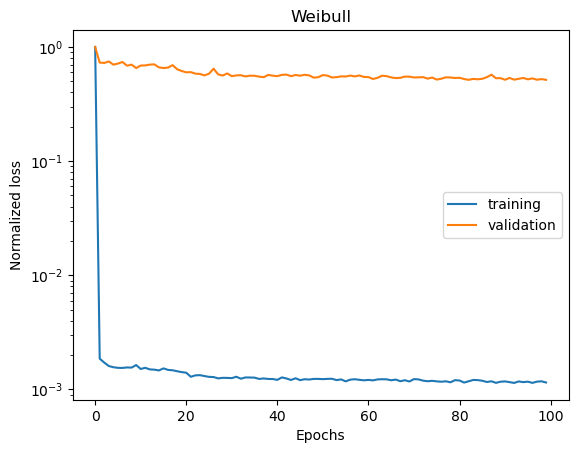

In [19]:
plot_losses(train_losses, val_losses, "Weibull")

### Section 2.3: Weibull AFT model evaluation

We evaluate the predictive performance of the model using 

* the [C-index](../_autosummary/torchsurv.metrics.cindex.html), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [AUC](../_autosummary/torchsurv.metrics.auc.html), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores, and
* the [Brier score](../_autosummary/torchsurv.metrics.brier_score.html), which measures the model's calibration by calculating the mean square error between the estimated survival function and the empirical (i.e., in-sample) event status.

We start by obtaining the subject-specific log hazard and survival probability at every time $t$ observed on the test set

In [33]:
with torch.no_grad():
    # event and time of length n
    x, (event, time) = next(iter(dataloader_test))
    log_params = weibull_model(x)  # shape = (n,2)

# Compute the log hazards from weibull log parameters
log_hz = log_hazard(log_params, time)  # shape = (n,n)

# Compute the survival probability from weibull log parameters
surv = survival_function(log_params, time)  # shape = (n,n)

torch.Size([206, 206])


We can evaluate the concordance index, its confidence interval and the p-value of the statistical test testing whether the c-index is greater than 0.5:

In [21]:
# Concordance index
weibull_cindex = ConcordanceIndex()
print("Weibull model performance:")
print(f"Concordance-index   = {weibull_cindex(log_hz, event, time)}")
print(f"Confidence interval = {weibull_cindex.confidence_interval()}")

# H0: cindex = 0.5, Ha: cindex >0.5
print(f"p-value             = {weibull_cindex.p_value(alternative = 'greater')}")

Weibull model performance:
Concordance-index   = 0.5990798473358154
Confidence interval = tensor([0.4707, 0.7275])
p-value             = 0.06523442268371582


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [34]:
new_time = torch.tensor(1825.0)

# subject-specific log hazard at \5-yr
log_hz_t = log_hazard(log_params, time=new_time)  # shape = (n)
weibull_auc = Auc()

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {weibull_auc(log_hz_t, event, time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {weibull_auc.confidence_interval()}")
print(f"AUC 5-yr (p value)   = {weibull_auc.p_value(alternative='greater')}")

AUC 5-yr             = tensor([0.5298])
AUC 5-yr (conf int.) = tensor([0.4742, 0.5854])
AUC 5-yr (p value)   = tensor([0.1467])
torch.Size([206])


Lastly, we can evaluate the time-dependent Brier score and the integrated Brier score

In [23]:
brier_score = BrierScore()

# brier score at first 5 times
print(f"Brier score             = {brier_score(surv, event, time)[:5]}")
print(f"Brier score (conf int.) = {brier_score.confidence_interval()[:,:5]}")

# integrated brier score
print(f"Integrated Brier score  = {brier_score.integral()}")

Brier score             = tensor([0.0849, 0.0897, 0.0969, 0.1017, 0.1075])
Brier score (conf int.) = tensor([[0.0661, 0.0696, 0.0757, 0.0798, 0.0845],
        [0.1037, 0.1099, 0.1181, 0.1237, 0.1304]])
Integrated Brier score  = 0.18183745443820953


We can test whether the time-dependent Brier score is smaller than what would be expected if the survival model was not providing accurate predictions beyond random chance. We use a bootstrap permutation test and obtain the p-value with:

In [24]:
# H0: bs = bs0, Ha: bs < bs0; where bs0 is the expected brier score if the survival model was not providing accurate predictions beyond random chance.

# p-value for brier score at first 5 times
print(f"Brier score (p-val)        = {brier_score.p_value(alternative = 'less')[:5]}")

Brier score (p-val)        = tensor([0.0090, 0.0420, 0.0490, 0.0700, 0.1420])


## Section 3: Models comparison

We can compare the predictive performance of the Cox proportional hazards model against the Weibull AFT model.

### Section 3.1: Concordance index
The statistical test is formulated as follows, H0: cindex cox = cindex weibull, Ha: cindex cox > cindex weibull

In [25]:
print(f"Cox cindex     = {cox_cindex.cindex}")
print(f"Weibull cindex = {weibull_cindex.cindex}")
print("p-value        = {}".format(cox_cindex.compare(weibull_cindex)))

Cox cindex     = 0.6743345260620117
Weibull cindex = 0.5990798473358154
p-value        = 0.16538496315479279


### Section 3.2: AUC at 5-year

The statistical test is formulated as follows, H0: 5-yr auc cox = 5-yr auc weibull, Ha: 5-yr auc cox > 5-yr auc weibull

In [26]:
print(f"Cox 5-yr AUC     = {cox_auc.auc}")
print(f"Weibull 5-yr AUC = {weibull_auc.auc}")
print("p-value          = {}".format(cox_auc.compare(weibull_auc)))

Cox 5-yr AUC     = tensor([0.7173])
Weibull 5-yr AUC = tensor([0.6096])
p-value          = tensor([0.0025])
